In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import matplotlib.dates as mds, seaborn as sns, datetime 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy import stats, signal
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from sklearn.cluster import DBSCAN
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

plt.rcParams['axes.grid'] = True

In [2]:
df = pd.read_excel('Data Analyst Test.xlsx')

In [3]:
df.columns

Index(['submitted_date', 'records', 'file_size_gb'], dtype='object')

In [4]:
df['submitted_date'] = pd.to_datetime(df['submitted_date'])

In [5]:
df[df['records'].gt(2.2e8)]

,submitted_date,records,file_size_gb
100,2020-07-01,220099737.0,179618.550297
109,2021-04-01,549866053.0,198305.233768
123,2022-06-01,252329115.0,192333.388544


In [6]:
def plot_df(df):  
    plt.figure(figsize=(12, 6))
    plt.subplots_adjust(wspace=0, hspace=0)
    ax1 = plt.subplot(2,1,1)
    ax1.plot(df['submitted_date'], df['records'])
    #ax1.set_xlabel('submitted_date')
    ax1.axvline(pd.Timestamp('2020-07'),color='b',linestyle='dashed', linewidth=0.8)
    ax1.axvline(pd.Timestamp('2021-04'),color='r',linestyle='dashed', linewidth=0.8)
    ax1.axvline(pd.Timestamp('2022-06'),color='b',linestyle='dashed', linewidth=0.8)
    ax1.scatter(df['submitted_date'][109], df['records'][109], color='r', marker='o', s=60, facecolors='None', label='anomaly removed')
    ax1.scatter(df['submitted_date'][[100, 123]], df['records'][[100, 123]], color='b', marker='o', s=60, facecolors='None', label='likely event interventions')
    #ax1.scatter(df['submitted_date'][123], df['records'][123], color='b', marker='o', s=60, facecolors='None')    
    ax1.xaxis.set_major_locator(mds.YearLocator())
    ax1.xaxis.set_major_formatter(mds.DateFormatter('%Y'))
    #ax1.grid()
    ax1.set_ylabel('records')
    ax1.yaxis.set_label_coords(-0.07,0.5)
    ax1.legend()

    ax2 = plt.subplot(2,1,2, sharex=ax1)
    ax2.plot(df['submitted_date'], df['file_size_gb'])
    ax2.set_xlabel('submitted_date')
    ax2.axvline(pd.Timestamp('2020-07'),color='b',linestyle='dashed', linewidth=0.8)
    ax2.axvline(pd.Timestamp('2021-04'),color='r',linestyle='dashed', linewidth=0.8)
    ax2.axvline(pd.Timestamp('2022-06'),color='b',linestyle='dashed', linewidth=0.8)
    #ax2.scatter(df['submitted_date'][109], df['file_size_gb'][109], color='r', marker='o', s=60, facecolors='None')
    ax2.xaxis.set_major_locator(mds.YearLocator())
    ax2.xaxis.set_major_formatter(mds.DateFormatter('%Y'))
    #ax2.grid()
    ax2.set_ylabel('file_size_gb')
    #ax2.text(1,2,'2020-07')

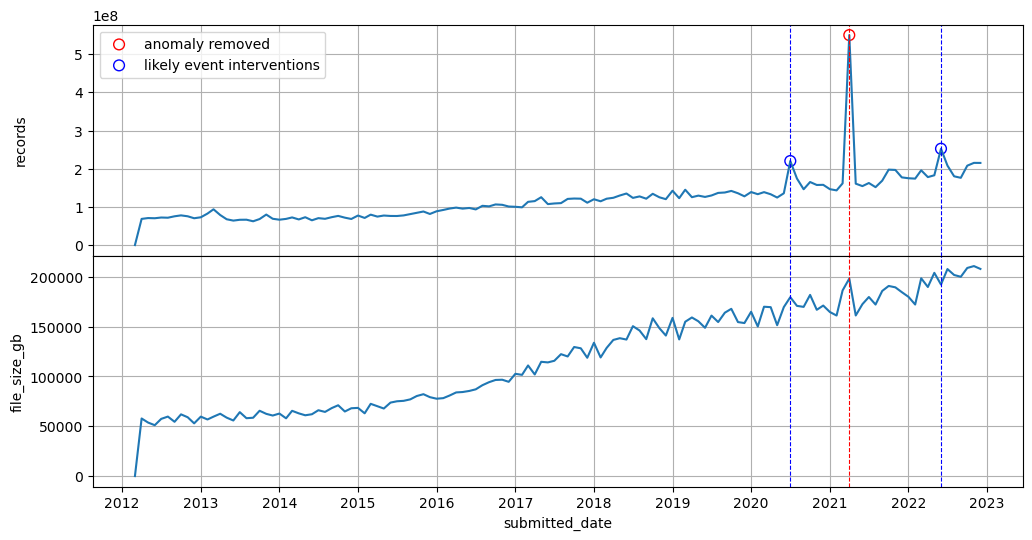

In [7]:
plot_df(df)

In [8]:
def IQR_outlier(df, IQR_level):
    
    #Compute Interquantile Range (IQR) to calculate the boundaries
    lower_quantile_rec, upper_quantile_rec = df['records'].quantile(0.25), df['records'].quantile(0.75)
    IQR_rec = upper_quantile_rec - lower_quantile_rec
    lower_quantile_fsize, upper_quantile_fsize = df['file_size_gb'].quantile(0.25), df['file_size_gb'].quantile(0.75)
    IQR_fsize = upper_quantile_fsize  - lower_quantile_fsize
    print('IQR_rec:{}, IQR_fsize:{}'.format(IQR_rec, IQR_fsize),'\n')
    
    # An observation is considered a suspected outlier or potential outlier if out of IQR1.5 range
    lower_range_rec = max(lower_quantile_rec-(IQR_rec*IQR_level),0)
    upper_range_rec = upper_quantile_rec+(IQR_rec*IQR_level)
    lower_range_fsize = max(lower_quantile_fsize-(IQR_fsize*IQR_level),0)
    upper_range_fsize = upper_quantile_fsize+(IQR_fsize*IQR_level)
    print('lower_quantile_rec:{}, upper_quantile_rec:{}, lower_quantile_fsize:{}, upper_quantile_fsize:{}'.format(lower_quantile_rec, upper_quantile_rec,lower_quantile_fsize, upper_quantile_fsize,'\n'))
    print('lower_range_rec:{}, upper_range_rec:{}, lower_range_fsize:{}, upper_range_fsize:{}'.format(lower_range_rec,upper_range_rec,lower_range_fsize,upper_range_fsize),'\n')

    outliers_rec = df[(df['records']>upper_range_rec) | (df['records']<lower_range_rec)]
    outliers_fsize = df[(df['file_size_gb']>upper_range_rec) | (df['file_size_gb']<lower_range_rec)]
    print(outliers_rec) 

In [9]:
IQR_level = 3
IQR_outlier(df, IQR_level)

IQR_rec:64430061.25, IQR_fsize:96646.37937625 

lower_quantile_rec:76652594.0, upper_quantile_rec:141082655.25, lower_quantile_fsize:67904.11444675, upper_quantile_fsize:164550.493823
lower_range_rec:0, upper_range_rec:334372839.0, lower_range_fsize:0, upper_range_fsize:454489.63195175 

    submitted_date      records   file_size_gb
109     2021-04-01  549866053.0  198305.233768


<AxesSubplot:>

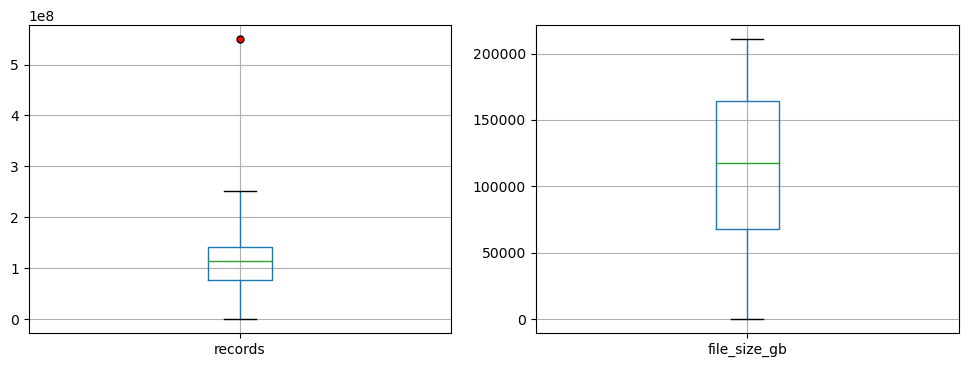

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
df.boxplot(['records'], whis=IQR_level, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'})
plt.subplot(1,2,2)
df.boxplot(['file_size_gb'], whis=IQR_level, flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'})

In [11]:
def DBSCAN_outlier(df):
    df_norm = df.drop(columns='submitted_date')
    df_norm = df_norm[:-1]
    df_norm = (df_norm-df_norm.min())/(df_norm.max()-df_norm.min())
    dbscan = DBSCAN(eps=0.1, min_samples=5).fit(df_norm)
    dbscan.fit(df_norm)
    labels = dbscan.labels_
    inds = np.argwhere(labels != 0).ravel()
    print(df.loc[inds])

In [12]:
def smooth_outlier(df,ind):
    dff = df.copy()
    dff.loc[ind,'records']=np.nan
    #dff.loc[ind,'file_size_gb']=np.nan
    dff['records'].interpolate(method='polynomial', order=33, inplace=True)
    #dff['file_size_gb'].interpolate(method='polynomial', order=3, inplace=True)
    r = dff['records'][-1:]
    f = dff['file_size_gb'][-1:]
    dff.loc[dff.index[-1], 'records'] = dff.loc[dff.index[-2], 'records']
    dff.loc[dff.index[-1], 'file_size_gb'] = dff.loc[dff.index[-2], 'file_size_gb']
    return dff

In [13]:
DBSCAN_outlier(df)

    submitted_date      records   file_size_gb
0       2012-03-01          0.0       0.000874
109     2021-04-01  549866053.0  198305.233768


In [14]:
dff = smooth_outlier(df, 109)

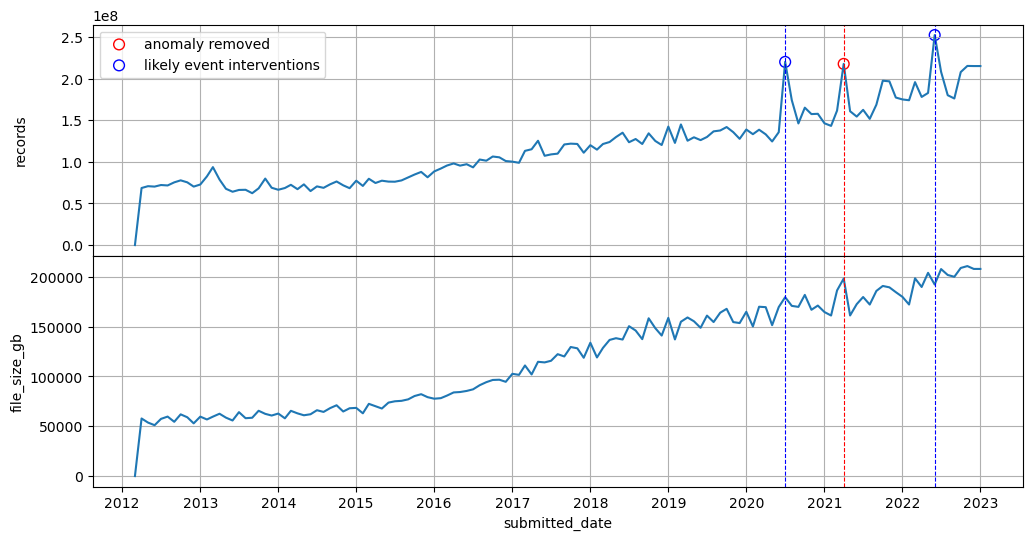

In [15]:
plot_df(dff)

In [16]:
dff.set_index('submitted_date', inplace=True)

In [17]:
def decompose_plot(dff):
    deco = seasonal_decompose(dff['file_size_gb'], model='additive',period=3)
    fig, ax = plt.subplots(3, 1, figsize=(12,9), sharex=True)
    plt.grid
    plt.subplots_adjust(hspace=0)
    plt.xlabel('submitted_date')
    deco.trend.plot(ax=ax[0])
    deco.seasonal.plot(ax=ax[1])
    deco.resid.plot(ax=ax[2])
    ax[0].set_ylabel('global trend')
    ax[1].set_ylabel('seasonal')
    ax[2].set_ylabel('residual')
    

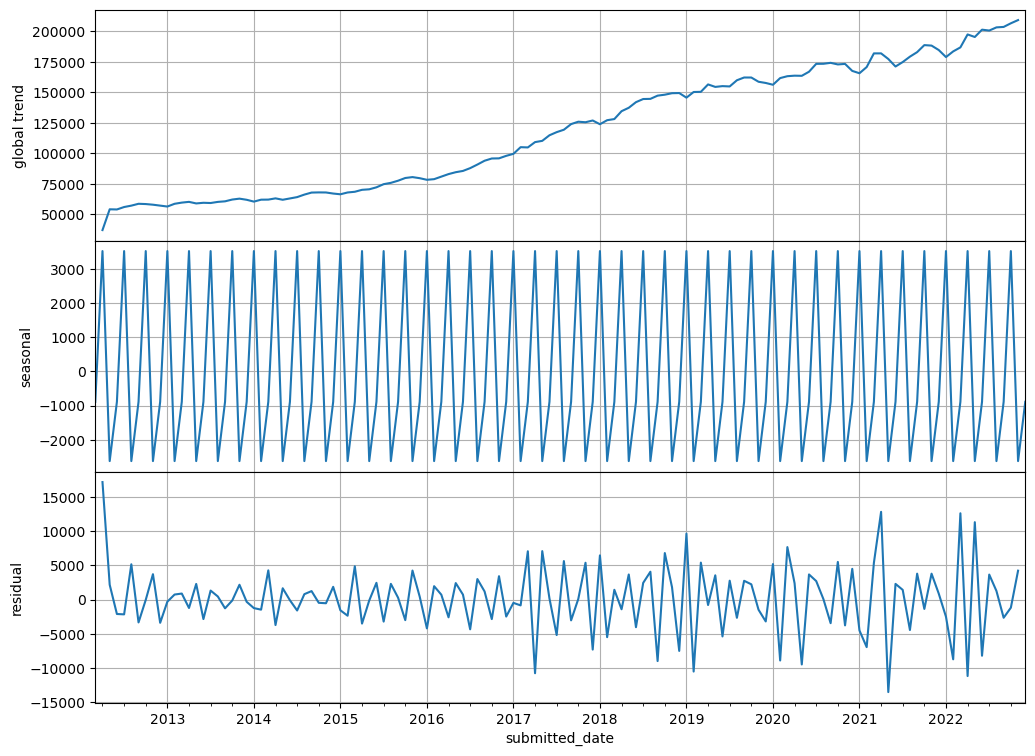

In [18]:
decompose_plot(dff[:-1])

In [19]:
def feat_corr_plot(dff):
    plt.scatter(dff['records'], dff['file_size_gb'], s=1, label='data')
    plt.xlabel('records')
    plt.ylabel('file_size_gb')
    mod1 = np.poly1d(np.polyfit(dff['records'], dff['file_size_gb'], 1))
    plt.plot(dff['records'], mod1(dff['records']), 'g', linewidth=1, label='linear regression')
    mod2 = np.poly1d(np.polyfit(dff['records'], dff['file_size_gb'], 5))
    sort_x = np.sort(dff['records'])
    plt.plot(sort_x, mod2(sort_x), 'r', linewidth=1, label='nonlinear regression')
    plt.hlines(max(dff['file_size_gb']), xmin=min(dff['records']), xmax=max(dff['records']), color='k', linewidth=0.5, linestyle='dashed')
    plt.hlines(180000, xmin=min(dff['records']), xmax=max(dff['records']), color='k', linewidth=0.5, linestyle='dashed')
    plt.fill_between(sort_x, max(dff['file_size_gb']), 180000, color='k', alpha=0.1)
    plt.legend()
    plt.figtext(0.4,0.65,'less correlated region')

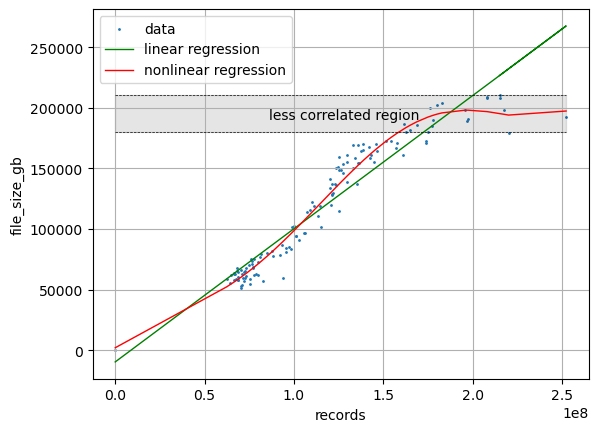

In [20]:
feat_corr_plot(dff[:-1])

(-50.0, 50.0)

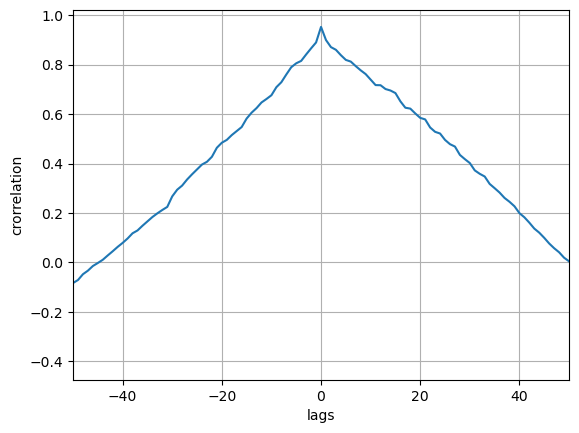

In [21]:
def cc(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
ccvs = cc(dff['records'], dff['file_size_gb'])
lags = signal.correlation_lags(len(dff['records']), len(dff['file_size_gb']))
plt.plot(lags, ccvs)
plt.xlabel('lags')
plt.ylabel('crorrelation')
plt.xlim(-50, 50)

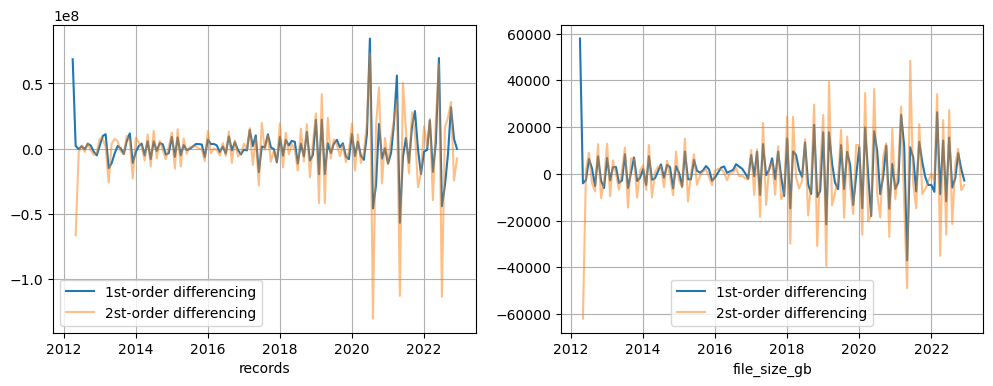

In [22]:
plt.figure(figsize=(12, 4))

ax1=plt.subplot(1,2,1)
ax1.plot(dff['records'][:-1].diff(), label='1st-order differencing')
ax1.plot(dff['records'][:-1].diff().diff(), label='2st-order differencing', alpha=0.5)
ax1.set_xlabel('records')
ax1.legend()

ax2=plt.subplot(1,2,2)
ax2.plot(dff['file_size_gb'][:-1].diff(), label='1st-order differencing')
ax2.plot(dff['file_size_gb'][:-1].diff().diff(), label='2st-order differencing', alpha=0.5)
ax2.set_xlabel('file_size_gb')
ax2.legend()


In [23]:
# stationairyt test for the variables
staionarity_test1 = adfuller(dff['records'][:-1].diff()[1:].diff()[1:], autolag='AIC')
print('staionarity_test for Records:')
print(f'ADF Statistic: {staionarity_test1[0]}')
print(f'p-value: {staionarity_test1[1]}')
for key, value in staionarity_test1[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
staionarity_test2 = adfuller(dff['file_size_gb'][:-1].diff()[1:].diff()[1:], autolag='AIC')
print('staionarity_test for file_size_gb:')
print(f'ADF Statistic: {staionarity_test2[0]}')
print(f'p-value: {staionarity_test2[1]}')
for key, value in staionarity_test2[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  
    
#The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. The null hypothesis suggest the time series is in fact non-stationary.


staionarity_test for Records:
ADF Statistic: -5.603901096554987
p-value: 1.246791026484494e-06
Critial Values:
   1%, -3.4885349695076844
Critial Values:
   5%, -2.887019521656941
Critial Values:
   10%, -2.5803597920604915
staionarity_test for file_size_gb:
ADF Statistic: -6.702136328719221
p-value: 3.865340168237063e-09
Critial Values:
   1%, -3.489057523907491
Critial Values:
   5%, -2.887246327182993
Critial Values:
   10%, -2.5804808802708528


In [24]:
"""
# define confidence interval
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

VAR_means, VAR_lower_CI, VAR_upper_CI = mean_confidence_interval(dff_forecast)
"""

'\n# define confidence interval\ndef mean_confidence_interval(data, confidence=0.95):\n    a = 1.0 * np.array(data)\n    n = len(a)\n    m, se = np.mean(a), scipy.stats.sem(a)\n    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)\n    return m, m-h, m+h\n\nVAR_means, VAR_lower_CI, VAR_upper_CI = mean_confidence_interval(dff_forecast)\n'

In [25]:
# plot fit testing data
def plot_test(dff, dff_forecast, hist_step):
    plt.figure(figsize=(12, 6))
    plt.subplots_adjust(wspace=0, hspace=0)
    ax1 = plt.subplot(2,1,1)
    ax1.plot(dff['records'][hist_step:], label='actual')
    ax1.plot(dff_forecast['records'], label='forcasted')
    ax1.set_ylabel('records')
    ax1.set_ylim(0, 3e8)
    ax1.legend()
    ax2 = plt.subplot(2,1,2, sharex=ax1)
    ax2.plot(dff['file_size_gb'][hist_step:], label='actual')
    ax2.plot(dff_forecast['file_size_gb'], label='predicted')
    ax2.set_xlabel('prediction time range')
    ax2.set_ylabel('file_size_gb')
    ax2.set_ylim(0, 300000)
    ax2.legend()

In [26]:
def wmape(actual, forecast):
    wmape = sum(abs(actual-forecast))/sum(actual)
    return wmape 
def rmspe(actual, forecast):
    rmspe = np.sqrt(sum(np.square((actual-forecast)/actual))/len(actual))
    return rmspe

In [27]:
# plot error metrics
def error_metrics(dff, dff_forecast, hist_step):
    pred_mape_rec =  mape(dff['records'][hist_step:-1], dff_forecast['records'][:-1])
    pred_mape_fsize = mape(dff['file_size_gb'][hist_step:-1], dff_forecast['file_size_gb'][:-1])
    pred_wmape_rec = wmape(dff['records'][hist_step:-1], dff_forecast['records'][:-1])
    pred_wmape_fsize = wmape(dff['file_size_gb'][hist_step:-1], dff_forecast['file_size_gb'][:-1])
    pred_rmspe_rec = rmspe(dff['records'][hist_step:-1], dff_forecast['records'][:-1])
    pred_rmspe_fsize = rmspe(dff['file_size_gb'][hist_step:-1], dff_forecast['file_size_gb'][:-1])
    print('Record MAPE: ', pred_mape_rec, 'Record WMAPE: ', pred_wmape_rec, 'Record RMSPE: ', pred_rmspe_rec)
    print('Upload file size MAPE: ', pred_mape_fsize, 'File size WMAPE: ', pred_wmape_fsize, 'File size RMSPE: ', pred_rmspe_fsize)
    print('prediction for 2023 Jan: \n', dff_forecast[-1:])

In [28]:
pred_step = 21
hist_step = len(dff)-pred_step
train, test = dff[:hist_step].values, dff[hist_step:].values
#dff_n, scale = df_norm(dff)
#dff1_inv = df_invnorm(dff_n, scale)

In [29]:
# ARIMA model file_size_gb
def ARIMA_(dff, hist_step: int, model_order: tuple):
    arima1 = ARIMA(dff['records'][:hist_step].values, order=model_order)  
    model_fitted1 = arima1.fit()  
    arima2 = ARIMA(dff['file_size_gb'][:hist_step].values, order=model_order)  
    model_fitted2 = arima2.fit()  
    fc1 = model_fitted1.forecast(pred_step)
    fc2 = model_fitted2.forecast(pred_step)
    dff_fc = pd.DataFrame(np.stack([fc1, fc2], axis=-1), index=dff.index[hist_step:], columns=dff.columns)
    plot_test(dff, dff_fc, hist_step)
    error_metrics(dff, dff_fc, hist_step)

In [30]:
# VAR model
def VAR_d0(dff, hist_step: int, model_order: int):
    var = VAR(endog=dff[:hist_step].values)
    var_fitted = var.fit(model_order)
    fc = var_fitted.forecast(y=train[-model_order:,:], steps=pred_step)
    dff_fc = pd.DataFrame(fc, index=dff.index[hist_step:], columns=dff.columns)
    plot_test(dff, dff_fc, hist_step)
    error_metrics(dff, dff_fc, hist_step)

In [31]:
# VAR-difference model
def VAR_d1(dff, hist_step: int, model_order: int):
    dff_d1 = dff.diff()
    model = VAR(endog=dff_d1[1:hist_step].values)
    model_fitted = model.fit(model_order)
    fc_d1 = model_fitted.forecast(y=dff_d1.values[-model_order:], steps=pred_step)
    dff_fc_d1 = pd.DataFrame(fc_d1, index=dff.index[hist_step:], columns=dff_d1.columns)
    for col in dff.columns:
        dff_fc_d1[str(col)] = dff[hist_step:][col][-1] + dff_fc_d1[str(col)].cumsum()
    plot_test(dff, dff_fc_d1, hist_step)
    error_metrics(dff, dff_fc_d1, hist_step)

C:\Users\User\anaconda3\envs\tfenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\anaconda3\envs\tfenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\anaconda3\envs\tfenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\anaconda3\envs\tfenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Record MAPE:  0.10518603465029426 Record WMAPE:  0.1091236751022419 Record RMSPE:  0.12802454998011542
Upload file size MAPE:  0.06390085083500477 File size WMAPE:  0.06124634218851962 File size RMSPE:  0.07729157528523467
prediction for 2023 Jan: 
                      records   file_size_gb
submitted_date                             
2023-01-01      1.895823e+08  212612.255709
Record MAPE:  0.0916214264734656 Record WMAPE:  0.09065905665280703 Record RMSPE:  0.1076335456578932
Upload file size MAPE:  0.13570070791004676 File size WMAPE:  0.13554148849127 File size RMSPE:  0.1464141386684861
prediction for 2023 Jan: 
                      records   file_size_gb
submitted_date                             
2023-01-01      2.138369e+08  246684.944462
Record MAPE:  0.23029904044424554 Record WMAPE:  0.22003924042527528 Record RMSPE:  0.2639940061386246
Upload file size MAPE:  0.18668138039095838 File size WMAPE:  0.18201129451927364 File size RMSPE:  0.20160823910670722
prediction for 202

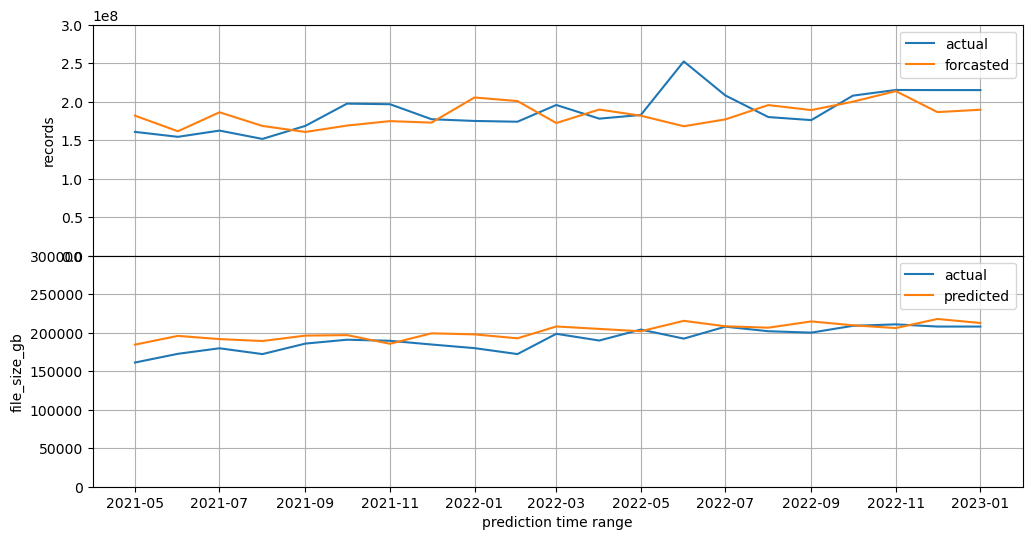

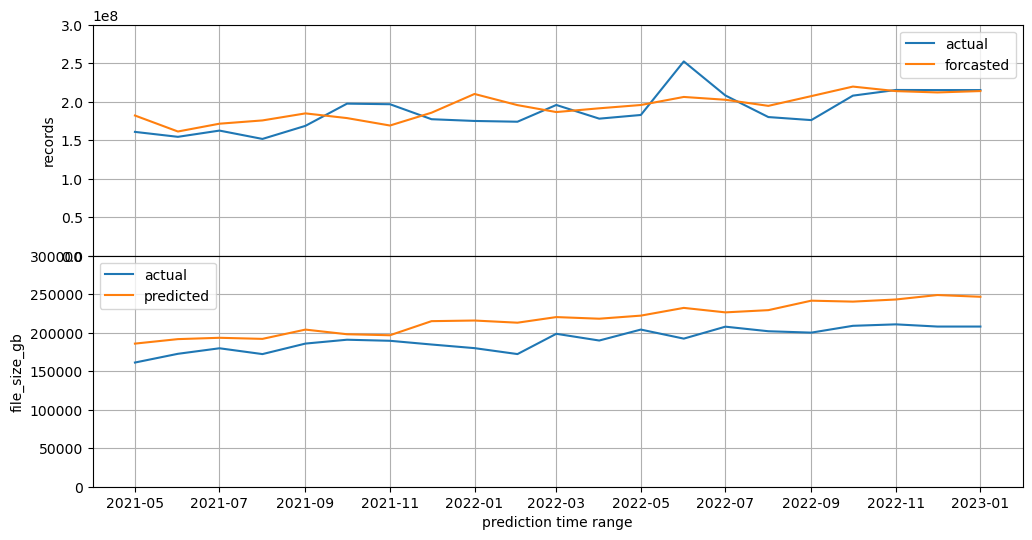

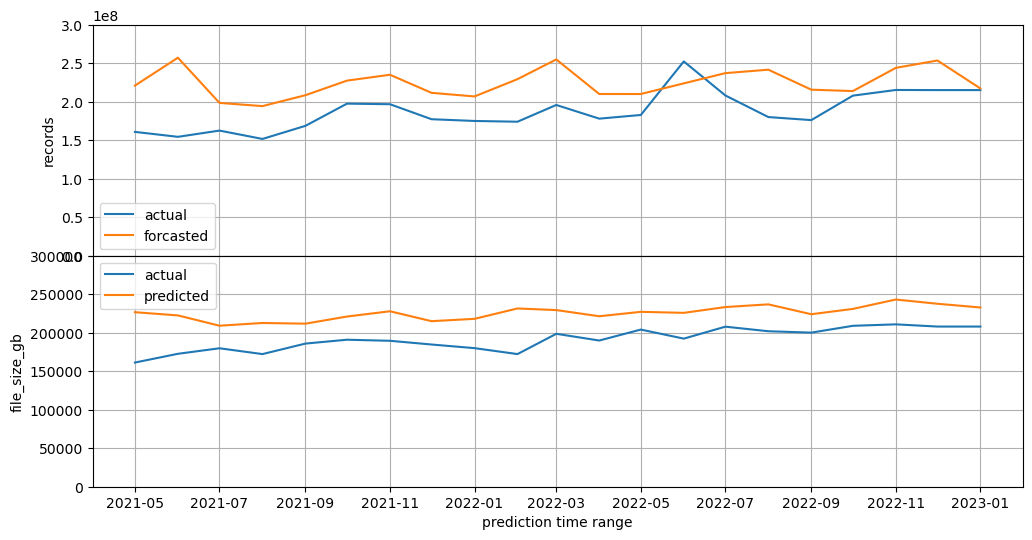

In [32]:
ARIMA_(dff, hist_step, model_order=(1, 1, 7))
VAR_d0(dff, hist_step=hist_step, model_order=9)
VAR_d1(dff, hist_step=hist_step, model_order=9)

In [33]:
def df_norm(df):
    scale = df.max()-df.min()
    df=(df-df.min())/scale
    return df, scale
def df_invnorm(df, scale):
    min_df = df.min()
    df=(df*scale)+min_df
    return df

"""
def train_test_norm(train_x, train_y, test_x, test_y):
    train_min, train_max = train_x.min(axis=0), train_x.max(axis=0)
    train_x_norm = (train_x-train_min)/(train_max-train_min)
    test_x_norm = (test_x-train_min)/(train_max-train_min)
    train_y_norm = (train_y-train_min)/(train_max-train_min)
    test_y_norm = (test_y-train_min)/(train_max-train_min)
    return train_x_norm, train_y_norm, test_x_norm, test_y_norm, train_min, train_max

def train_test_invnorm(train_x_norm, train_y_norm, test_x_norm, test_y_norm, train_min, train_max):
    train_x_inv = train_norm*(train_max-train_min)+train_min
    test_x_inv = test_norm*(train_max-train_min)+train_min
    train_y_inv = train_y_norm*(train_max-train_min)+train_min
    test_y_inv = test_y_norm*(train_max-train_min)+train_min
    return train_x_inv, train_y_inv, test_x_inv, test_y_inv
"""

'\ndef train_test_norm(train_x, train_y, test_x, test_y):\n    train_min, train_max = train_x.min(axis=0), train_x.max(axis=0)\n    train_x_norm = (train_x-train_min)/(train_max-train_min)\n    test_x_norm = (test_x-train_min)/(train_max-train_min)\n    train_y_norm = (train_y-train_min)/(train_max-train_min)\n    test_y_norm = (test_y-train_min)/(train_max-train_min)\n    return train_x_norm, train_y_norm, test_x_norm, test_y_norm, train_min, train_max\n\ndef train_test_invnorm(train_x_norm, train_y_norm, test_x_norm, test_y_norm, train_min, train_max):\n    train_x_inv = train_norm*(train_max-train_min)+train_min\n    test_x_inv = test_norm*(train_max-train_min)+train_min\n    train_y_inv = train_y_norm*(train_max-train_min)+train_min\n    test_y_inv = test_y_norm*(train_max-train_min)+train_min\n    return train_x_inv, train_y_inv, test_x_inv, test_y_inv\n'

5-fold CV score for feature 'Record': [0.75759093 0.85646639 0.85831587 0.84267007 0.85344051] 

5-fold CV score for feature 'file_size_gb': [0.97144889 0.97414191 0.98892224 0.98263265 0.97918771] 

Record MAPE:  0.09675642454938553 Record WMAPE:  0.10348454921278599 Record RMSPE: 
 0.12939980288636538
Upload file size MAPE:  0.04452447094023797 File size WMAPE:  0.048476995032584014 File size RMSPE:
 0.05269592497591032
records prediction for 2023 Jan: 
 [2.15661475e+08]
file size prediction for 2023 Jan: 
 [206661.05009226]


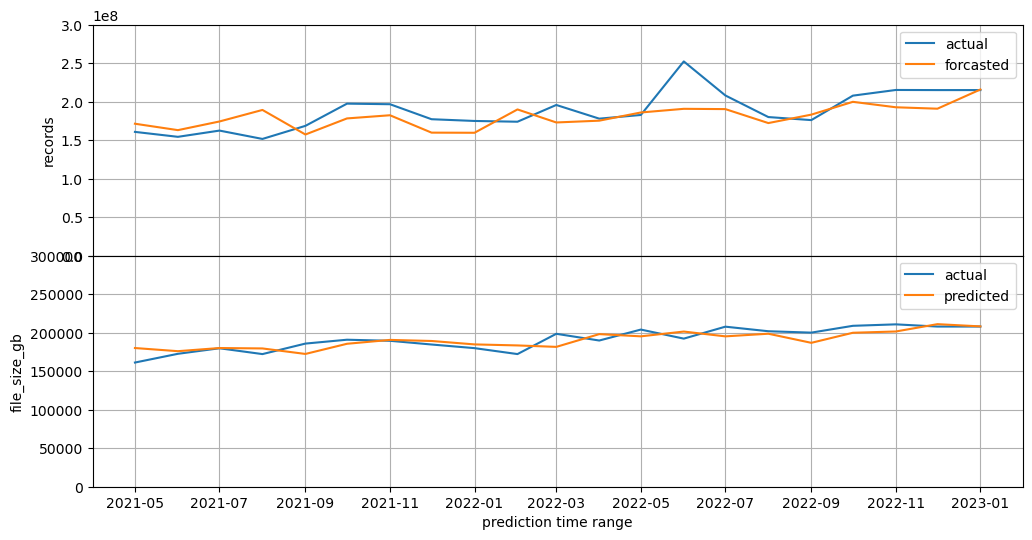

In [53]:
def data_shift(data, back_step, head_step, s):
    samples = int(np.ceil((len(data)-(back_step+head_step))/s)+1)
    x = np.stack([data[s*i:back_step+s*i,:] for i in range(samples)], axis=0)
    y = np.stack([data[back_step+s*i:back_step+head_step+s*i,:] for i in range(samples)], axis=0)
    return x, y

# define lookback range, prediction range, sampling gaps
back_step, head_step, s = 10, 1, 1

# train test split

dff_norm, scale = df_norm(dff)

x, y = data_shift(dff_norm[:-1].values, back_step=back_step, head_step=head_step, s=s)
ind = np.random.permutation(len(x))
x_, y_ = np.array([x[ind[i]] for i in range(len(x))]), np.array([y[ind[i]] for i in range(len(x))])
train_x0, train_y0 = x_[:hist_step-back_step,:,0], y_[:hist_step-back_step,:,0].reshape(-1)
test_x0, test_y0 = x_[hist_step-back_step:,:,0], y_[hist_step-back_step:,:,0].reshape(-1)
train_x1, train_y1 = x_[:hist_step-back_step,:,1], y_[:hist_step-back_step,:,1].reshape(-1)
test_x1, test_y1 = x_[hist_step-back_step:,:,1], y_[hist_step-back_step:,:,1].reshape(-1)

# XGBoost model
#train_x0, train_y0, test_x0, test_y0 = train_x0, train_y0, test_x0, test_y0   ####
#model = XGBRegressor(n_estimators=100, max_depth=5, tree_method="hist", eval_metric=mape)

# SVR
svr = SVR(kernel = 'rbf', C=1, epsilon=0.001)
model = svr.fit(train_x0, train_y0)

# cross validation scores
cv=5
scores0 = cross_val_score(model, train_x0, train_y0, cv=cv)
scores1 = cross_val_score(model, train_x1, train_y1, cv=cv)
print("{}-fold CV score for feature 'Record': {} \n".format(cv, scores0))
print("{}-fold CV score for feature 'file_size_gb': {} \n".format(cv, scores1))

# fit and test the model
trained_model0 = model.fit(train_x0, train_y0)
trained_model1 = model.fit(train_x1, train_y1)
test_fc0 = trained_model0.predict(test_x0)
test_fc1 = trained_model1.predict(test_x1)


# prediction for 23023 Jan values
pred_2023_Jan_rec = trained_model0.predict(np.array(dff_norm.iloc[-back_step-1:-1,0]).reshape(1,-1))
pred_2023_Jan_fsize = trained_model1.predict(np.array(dff_norm.iloc[-back_step-1:-1,1]).reshape(1,-1))

# predict the defined 'pred_step' time range to plot continuous curves
fc1 = np.array([trained_model0.predict(x[-pred_step+i,:,0].reshape(1,-1)) for i in range(pred_step)]).reshape(-1) ##
fc2 = np.array([trained_model1.predict(x[-pred_step+i,:,1].reshape(1,-1)) for i in range(pred_step)]).reshape(-1)

# merge predictions of all features to DataFrame
dff_fc_norm = pd.DataFrame(np.stack([fc1, fc2], axis=-1), index=dff_norm.index[hist_step:], columns=dff_norm.columns)

# de-normalization
dff_fc = df_invnorm(dff_fc_norm, scale)

# results:

plot_test(dff, dff_fc, hist_step)

pred_mape_rec =  mape(test_y0, test_fc0)
pred_mape_fsize = mape(test_y1, test_fc1)
pred_wmape_rec = wmape(test_y0, test_fc0)
pred_wmape_fsize = wmape(test_y1, test_fc1)
pred_rmspe_rec = rmspe(test_y0, test_fc0)
pred_rmspe_fsize = rmspe(test_y1, test_fc1)
print('Record MAPE: ', pred_mape_rec, 'Record WMAPE: ', pred_wmape_rec, 'Record RMSPE: \n', pred_rmspe_rec)
print('Upload file size MAPE: ', pred_mape_fsize, 'File size WMAPE: ', pred_wmape_fsize, 'File size RMSPE:\n', pred_rmspe_fsize)
print('records prediction for 2023 Jan: \n', pred_2023_Jan_rec*scale[0]+dff.min()[0])
print('file size prediction for 2023 Jan: \n', pred_2023_Jan_fsize*scale[1]+dff.min()[1])


In [51]:
scale

records         2.523291e+08
file_size_gb    2.108651e+05
dtype: float64